This is an attempt to apply Kmeans clustering on the graph. The steps are as follows:


*   Generate Graph.
*   If the graph has disconnected components, seperate them and act on them individually
*   Calculate a derived distance metric by multiplying the wire length with number of wires.
*   Select an input node in the subgraph and then find the length of all the nodes from that input node.
*   Project this onto a 1D plane, using the fact that projected distance = exp^(-derived distance metric)
*   Now apply Kmeans.
*   Doing this for every subgraph, calculate the critical path.

In [1]:
#Graph Gen 1.2
# Added inputs and outputs
# The power consumption for a node ranges from 1 to 50 units and uniformly distributed.
# Plus the area may vary from 1 to 5 units as well, uniformly distributed
# Ensured the following:
# The input nodes must have at least one outgoing edge and no incoming edge
# The output nodes must have one incoming edge only
# Internal nodes must have at least one incoming and at least one outgoing edge
import networkx as nx
import numpy as np
import math
import random
import matplotlib.pyplot as plt

def generate_netlist(
    num_nodes=50,
    num_edges=100,
    enable_area=True,
    #Area (chip constraints) of the node or the gate assembly
    enable_power=True,
    # Power consumption of the gate (used to optimize or reduce heat generation or power consumption per chip)
    enable_wire_count=True,
    # Number of wires represented by an edge
    enable_distance=True,
    # Distance of the wire to calculate power dissipation and delay
    seed = None
):
    """Generates a netlist as a directed graph with specific connectivity constraints."""
    if seed:
        random.seed(seed)
        np.random.seed(seed)
    #Generate a directed graph
    G = nx.DiGraph()

    # Estimate number of inputs and outputs
    # Assuming num_inputs and num_outputs to be the functions below
    num_inputs = math.ceil(math.log2(num_nodes))
    num_outputs = math.ceil(num_inputs / 2)
    input_nodes = [f"IN_{i}" for i in range(num_inputs)]
    output_nodes = [f"OUT_{i}" for i in range(num_outputs)]
    internal_nodes = [f"N_{i}" for i in range(num_nodes)]

    # Create internal nodes with attributes
    # Area carying from A to 5A
    # Power Consumption varying from P to 50P
    for node in internal_nodes:
        G.add_node(node)
        if enable_area:
            G.nodes[node]['area'] = round(random.uniform(1.0, 5.0), 2)
        if enable_power:
            G.nodes[node]['power'] = round(random.uniform(1.0, 50.0), 2)

    # Create input and output nodes
    for node in input_nodes + output_nodes:
        G.add_node(node)

    # Ensure input nodes have at least one outgoing edge
    for input_node in input_nodes:
        target = random.choice(internal_nodes)
        G.add_edge(input_node, target)

    # Ensure output nodes have exactly one incoming edge
    for output_node in output_nodes:
        source = random.choice(internal_nodes)
        G.add_edge(source, output_node)

    # Ensure internal nodes have at least one incoming and one outgoing edge
    # i.e. no gate is useless in the circuit
    for node in internal_nodes:
        if G.in_degree(node) == 0:
            source = random.choice(input_nodes + internal_nodes)
            G.add_edge(source, node)
        if G.out_degree(node) == 0:
            target = random.choice(internal_nodes + output_nodes)
            G.add_edge(node, target)

    # Add additional edges up to num_edges while preventing duplicate edges and self-loops
    existing_edges = set(G.edges())
    while len(G.edges()) < num_edges:
        u, v = random.sample(internal_nodes, 2)
        if u != v and (u, v) not in existing_edges:
            G.add_edge(u, v)
            existing_edges.add((u, v))

    # Assign edge attributes
    for u, v in G.edges():
        if enable_wire_count:
            G.edges[u, v]['wires'] = random.randint(1, 5)
        if enable_distance:
            G.edges[u, v]['distance'] = round(random.uniform(1.0, 10.0), 2)

    return G, input_nodes, output_nodes

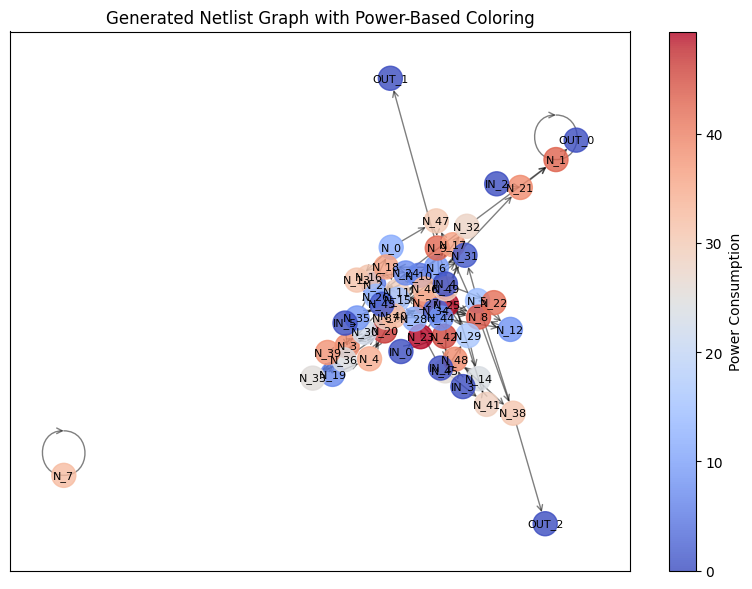

In [2]:

def visualize_netlist(G):
    pos = nx.spring_layout(G, seed=42)
    power_values = [G.nodes[n].get('power', 0) for n in G.nodes()]

    plt.figure(figsize=(10, 7))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=power_values, cmap='coolwarm', alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.5, arrowstyle='->', arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)

    cbar = plt.colorbar(nodes)
    cbar.set_label("Power Consumption")
    plt.title("Generated Netlist Graph with Power-Based Coloring")
    plt.show()

# Example usage
graph, inputs, outputs = generate_netlist(num_nodes=50, num_edges=100)
visualize_netlist(graph)


We will first seperate any disconnected components and generate subgraphs.
Any disconnected components can be directly declared clusters if they are of small size or at least can be worked upon indipendently.

In [3]:

def separate_disconnected_subgraphs(G):
    """
    Identifies and separates disconnected portions of the graph.

    Parameters:
    - G: A directed graph (DiGraph)

    Returns:
    - List of subgraphs (as NetworkX DiGraphs), where each subgraph is a disconnected portion.
    """
    subgraphs = []

    # Convert to undirected graph to find connected components
    undirected_G = G.to_undirected()

    # Find connected components
    # Using the NetworkX library to check if the undirected graph is connected
    for component in nx.connected_components(undirected_G):
        subgraph = G.subgraph(component).copy()  # Preserve directionality in subgraph
        subgraphs.append(subgraph)

    # Return the library of subgraphs
    return subgraphs


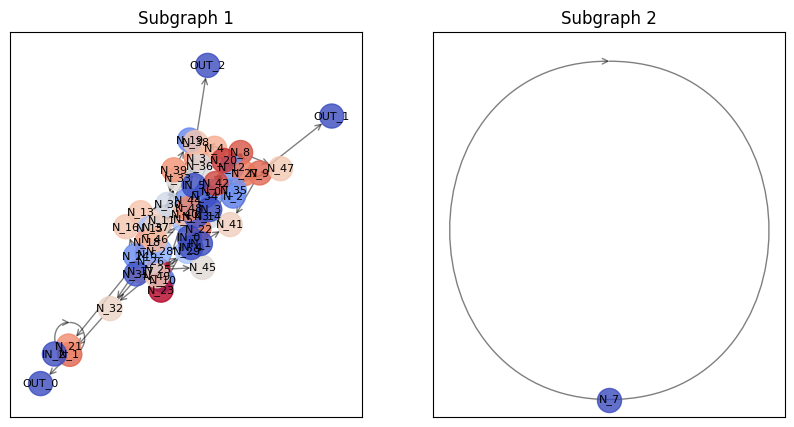

In [4]:
# Just a visualization
def visualize_disconnected_subgraphs(G):
    subgraphs = separate_disconnected_subgraphs(G)  # Get isolated components
    num_subgraphs = len(subgraphs)

    fig, axes = plt.subplots(1, num_subgraphs, figsize=(5 * num_subgraphs, 5))

    if num_subgraphs == 1:  # Ensure axes is iterable even for one subgraph
        axes = [axes]

    for ax, subG in zip(axes, subgraphs):
        pos = nx.spring_layout(subG, seed=42)  # Layout for consistency
        power_values = [subG.nodes[n].get('power', 0) for n in subG.nodes()]

        nodes = nx.draw_networkx_nodes(subG, pos, node_color=power_values, cmap='coolwarm', alpha=0.8, ax=ax)
        nx.draw_networkx_edges(subG, pos, alpha=0.5, arrowstyle='->', arrows=True, ax=ax)
        nx.draw_networkx_labels(subG, pos, font_size=8, ax=ax)

        ax.set_title(f"Subgraph {subgraphs.index(subG) + 1}")

    plt.show()

visualize_disconnected_subgraphs(graph)


Derived Distance metric to signify the closeness of two nodes is:

Derived distance = wire_distance * num_wires
This value would be greater for closely connected nodes. Hence we need to come up with an inverse relationship for a 1D projection.

This relationship is:
Projected distance = exp(-Derived Distance/Mean of Derived Distances)


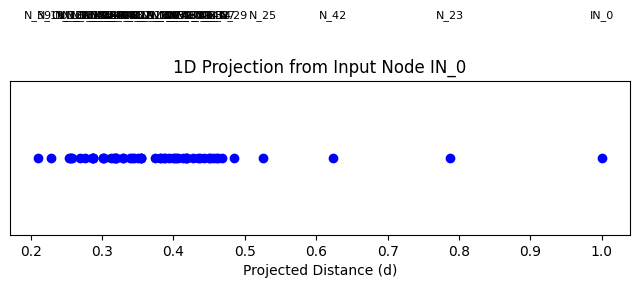

In [5]:
# Computes the distance metric d = wire_distance * number_of_wires
# This resembles the closeness of two nodes or gates
def compute_edge_weights(G):
    """Modifies G to have a custom distance metric d = wire_distance * num_wires."""
    for u, v in G.edges():
        # Extract edge weights and calculate the custom weights
        wire_distance = G.edges[u, v].get("distance", 1)
        num_wires = G.edges[u, v].get("wires", 1)
        G.edges[u, v]["d"] = wire_distance * num_wires

# Computing paths from the input node
def compute_1d_projection(G, input_node):
    """Computes transformed shortest path distances from an input node to all other nodes."""
    # Convert to undirected graph to allow dijkstra's algorithm
    G_undirected = G.to_undirected()

    # Compute shortest path distances using the custom edge weight
    raw_distances = nx.single_source_dijkstra_path_length(G_undirected, input_node, weight="d")

    # These raw_distances are larger for closely connected nodes
    # So we must find an inverse relationship with the derived metric
    # We choose exp(-dist/mean)
    # Convert distances to ensure closer connections have smaller projected distances
    if len(raw_distances) > 0:
        mean_d = np.mean(list(raw_distances.values()))
        transformed_distances = {node: np.exp(-dist / mean_d) for node, dist in raw_distances.items()}
    else:
        transformed_distances = raw_distances  # If no distances, return as is

    return transformed_distances

# Visualize projection (just for troublehsooting)
def visualize_1d_projection(G, input_node):
    """Visualizes nodes projected onto a 1D line based on distance from input node."""
    distances = compute_1d_projection(G, input_node)

    plt.figure(figsize=(8, 2))

    # Sort nodes based on distance
    sorted_nodes = sorted(distances.items(), key=lambda x: x[1])

    # Plot nodes on a 1D line
    for i, (node, dist) in enumerate(sorted_nodes):
        plt.scatter(dist, 0, color="blue")
        plt.text(dist, 0.1, str(node), fontsize=8, ha="center")

    plt.xlabel("Projected Distance (d)")
    plt.yticks([])  # Remove y-axis
    plt.title(f"1D Projection from Input Node {input_node}")
    plt.show()

# This is important as the input nodes may be divided across subgraphs
def get_valid_input_node(subgraph, input_nodes):
    """Finds a valid input node present in the given subgraph."""
    for node in input_nodes:
        if node in subgraph.nodes():
            return node
    return None  # No input node in this subgraph

# Compute edge weights
compute_edge_weights(graph)

# Get subgraphs
subgraphs = separate_disconnected_subgraphs(graph)

# Find a subgraph with an input node
valid_subgraph = None
valid_input = None

for subgraph in subgraphs:
    valid_input = get_valid_input_node(subgraph, inputs)
    if valid_input:
        valid_subgraph = subgraph
        break  # Stop after finding the first valid subgraph

# Only visualize if we found a valid subgraph and input
if valid_subgraph and valid_input:
    visualize_1d_projection(valid_subgraph, valid_input)
else:
    print("No valid subgraph contains an input node.")


Final: Cuts = 2, Total Wire Length = 621.2099999999999, Critical Length = 193.91
Final: Cuts = 25, Total Wire Length = 1933.0500000000004, Critical Length = 754.1900000000003
Final: Cuts = 37, Total Wire Length = 2544.9599999999996, Critical Length = 594.71
Final: Cuts = 54, Total Wire Length = 3461.97, Critical Length = 968.83
Final: Cuts = 58, Total Wire Length = 3548.639999999999, Critical Length = 968.83
Final: Cuts = 63, Total Wire Length = 3757.439999999999, Critical Length = 875.23
Final: Cuts = 66, Total Wire Length = 3815.5799999999995, Critical Length = 1059.7200000000003
Final: Cuts = 68, Total Wire Length = 3902.0699999999997, Critical Length = 1121.64
Final: Cuts = 75, Total Wire Length = 4149.84, Critical Length = 1108.38
Final: Cuts = 72, Total Wire Length = 4125.72, Critical Length = 1351.7


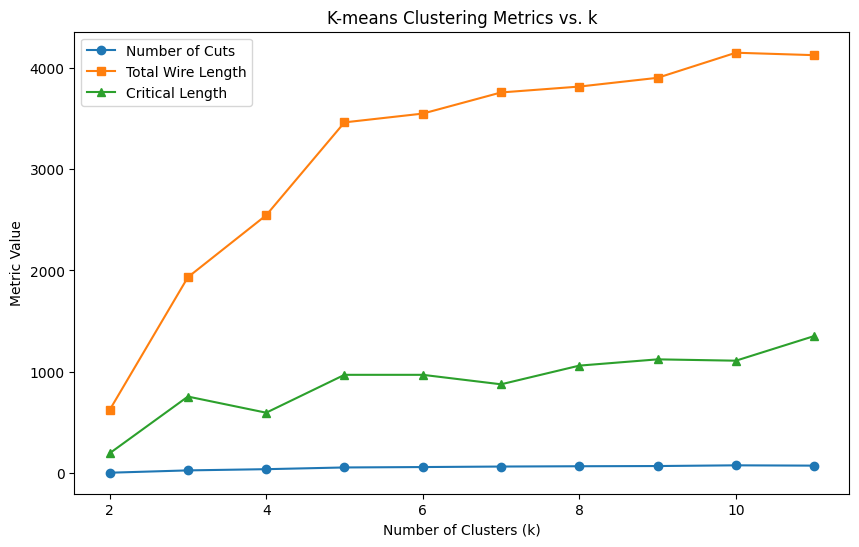

Optimal k = 2 with Critical Length = 193.91


In [6]:
def apply_kmeans_clustering(projections, num_clusters):
    """Applies K-means clustering on 1D projections"""
    # Randomly initialize cluster centroids from the 1D projection
    centroids = random.sample(list(projections.values()), num_clusters)
    clusters = {i: [] for i in range(num_clusters)}

    for _ in range(100):  # Iterate for convergence
        new_clusters = {i: [] for i in range(num_clusters)}

        # Assign nodes to nearest centroid
        # Also using absolute distance here
        for node, dist in projections.items():
            closest = min(range(num_clusters), key=lambda c: abs(dist - centroids[c]))
            new_clusters[closest].append(node)

        # Recalculate centroids
        # Cluster empty case means the centroid will remain unchanged
        new_centroids = []
        for i in range(num_clusters):
            if new_clusters[i]:
                new_centroids.append(np.mean([projections[n] for n in new_clusters[i]]))
            else:
                # Empty Cluster case
                new_centroids.append(centroids[i])

        # If centroids do not change much, we stop iterations
        if np.allclose(centroids, new_centroids, atol=1e-3):
            break

        # Re-assigning centroids and clusters
        centroids = new_centroids
        clusters = new_clusters

    # Assign cluster labels
    cluster_labels = {}
    for cluster_id, nodes in clusters.items():
        for node in nodes:
            cluster_labels[node] = cluster_id

    return cluster_labels

# Just for visualizing the clustered graph
# Same colour = Same cluster
def visualize_clustered_graph(G, cluster_labels):
    """Visualizes the graph with cluster-based coloring."""
    pos = nx.spring_layout(G, seed=42)
    unique_clusters = set(cluster_labels.values())
    colors = plt.cm.get_cmap("tab10", len(unique_clusters))

    plt.figure(figsize=(10, 7))
    for cluster in unique_clusters:
        nodes = [n for n, c in cluster_labels.items() if c == cluster]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=[colors(cluster)], alpha=0.8)

    nx.draw_networkx_edges(G, pos, alpha=0.5, arrowstyle='->', arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title("Clustered Netlist Graph")
    plt.show()

# Calculates the optimizations like number of cuts and total wire length
def compute_wire_metrics(G, cluster_labels, input_nodes, output_node):
    """Computes the number of cuts and total wire length."""
    # Number of intercluster wires
    num_cuts = 0
    # Total wirelength, both intra and inter cluster
    total_wire_length = 0

    # Convert G to a directed graph for longest path calculation
    G_weighted = nx.DiGraph()

    for u, v in G.edges():
        wire_length = G.edges[u, v].get("distance", 1)
        cluster_u, cluster_v = cluster_labels.get(u), cluster_labels.get(v)

        if cluster_u == cluster_v:
            edge_weight = wire_length  # Intracluster
        else:
            edge_weight = wire_length * 10  # Intercluster
            num_cuts += 1
            # Note intercluster distances get multiplied by 10

        total_wire_length += edge_weight
        G_weighted.add_edge(u, v, weight=edge_weight)  # Construct weighted graph

    # Remove cycles if any
    while not nx.is_directed_acyclic_graph(G_weighted):
        try:
            cycle = next(nx.simple_cycles(G_weighted))  # Find a cycle
            min_edge = min(
                ((cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))),
                key=lambda e: G_weighted.edges[e].get("weight", 1)
            )
            G_weighted.remove_edge(*min_edge)  # Remove lowest-weight edge
        except StopIteration:
            break

    # Find the critical length (longest path from any input node to output)
    critical_length = 0
    for input_node in input_nodes:
        if input_node in G_weighted.nodes:
            for output_node in output_node:  # Iterate over all output nodes
                if output_node in G_weighted.nodes:
                    try:
                      path = nx.dag_longest_path(G_weighted, weight="weight")
                      path_length = sum(G_weighted[u][v]["weight"] for u, v in zip(path, path[1:]))
                      critical_length = max(critical_length, path_length)
                    except nx.NetworkXNoPath:
                        pass  # No valid path exists for this input-output pair

    print(f"Final: Cuts = {num_cuts}, Total Wire Length = {total_wire_length}, Critical Length = {critical_length}")
    return num_cuts, total_wire_length, critical_length

# Calls each method and carries out process from feature extraction to computing results
def Kmeans_1(graph, inputs, outputs):
    """Processes each subgraph, applies K-means, and visualizes clusters."""
    # Calls method to compute edge weights
    compute_edge_weights(graph)
    # Seperate disconnected subgraphs for easier processing on smaller subgraphs
    subgraphs = separate_disconnected_subgraphs(graph)

    #Now, act on each subgraph
    for subgraph in subgraphs:
        #For each subgraph,get an input node
        input_node = get_valid_input_node(subgraph, inputs)
        if not input_node:
            continue  # Skip if no input node

        # Calculate the distance from that input node and then project it onto a 1D space
        projections = compute_1d_projection(subgraph, input_node)
        num_nodes = len(subgraph.nodes())
        # Initializing best_k=2
        best_k = 2
        # Intialize other parameters or test metrics
        best_critical_length = float('inf')
        k_values, cuts, wire_lengths, critical_lengths = [], [], [], []

        # Keeping the minimum number of nodes per cluster to be 5
        for k in range(2, max(2, num_nodes // 5) + 1):
            # Run Kmeans and then calculate the test metrics
            cluster_labels = apply_kmeans_clustering(projections, k)
            num_cuts, total_wire_length, critical_length = compute_wire_metrics(subgraph, cluster_labels, inputs, outputs)

            k_values.append(k)
            cuts.append(num_cuts)
            wire_lengths.append(total_wire_length)
            critical_lengths.append(critical_length)

            if critical_length < best_critical_length:
                best_critical_length = critical_length
                best_k = k


        plt.figure(figsize=(10, 6))
        plt.plot(k_values, cuts, label="Number of Cuts", marker='o')
        plt.plot(k_values, wire_lengths, label="Total Wire Length", marker='s')
        plt.plot(k_values, critical_lengths, label="Critical Length", marker='^')
        plt.xlabel("Number of Clusters (k)")
        plt.ylabel("Metric Value")
        plt.title("K-means Clustering Metrics vs. k")
        plt.legend()
        plt.show()

        # This is a bit flawed because obviously, the crtitical length would be quite less if there are no inter-cluster wires
        print(f"Optimal k = {best_k} with Critical Length = {best_critical_length}")
        cluster_labels = apply_kmeans_clustering(projections, best_k)

# Example usage
Kmeans_1(graph, (inputs), (outputs))